In [21]:
#Importing used libraries
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly

### Displaying initial columns in cleaned data

In [22]:

df = pd.read_csv('../data/lrpd-clean.csv')
df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'])
df.head().T


,0,1,2,3,4
INCIDENT_NUMBER,2022-036059,2017-029450,2017-114829,2018-046714,2020-042339
INCIDENT_DATE,2022-03-30 17:38:00,2017-03-16 18:30:00,2017-09-15 03:14:00,2018-04-20 16:18:00,2020-04-18 18:15:00
LOCATION_DISTRICT,42.0,82.0,64.0,82.0,61.0
OFFENSE_DESCRIPTION,THEFT FROM MOTOR VEHICLE,THEFT OF MOTOR VEHICLE PARTS,RAPE,RAPE,RAPE
WEAPON_TYPE,NO WEAPON,NO WEAPON,NO WEAPON,UNKNOWN,HANDGUN
ZIP,72202.0,72206.0,0.0,0.0,0.0
LATITUDE,0.0,34.649362,0.0,0.0,0.0
LONGITUDE,0.0,-92.301959,0.0,0.0,0.0
WEEK_OF_MONTH,4,2,2,2,2
YEAR,2022,2017,2017,2018,2020


### Creating a new dataframe containing daily counts of incidents and renaming columns according to Prophet's requirements

In [23]:
df2 = df.groupby(pd.Grouper(key='INCIDENT_DATE', freq='D')).size().reset_index(name='INCIDENT_COUNT')
df2.columns = ['ds', 'y']
df2.tail()

,ds,y
2237,2023-02-16,42
2238,2023-02-17,32
2239,2023-02-18,25
2240,2023-02-19,36
2241,2023-02-20,30


<AxesSubplot:xlabel='ds'>

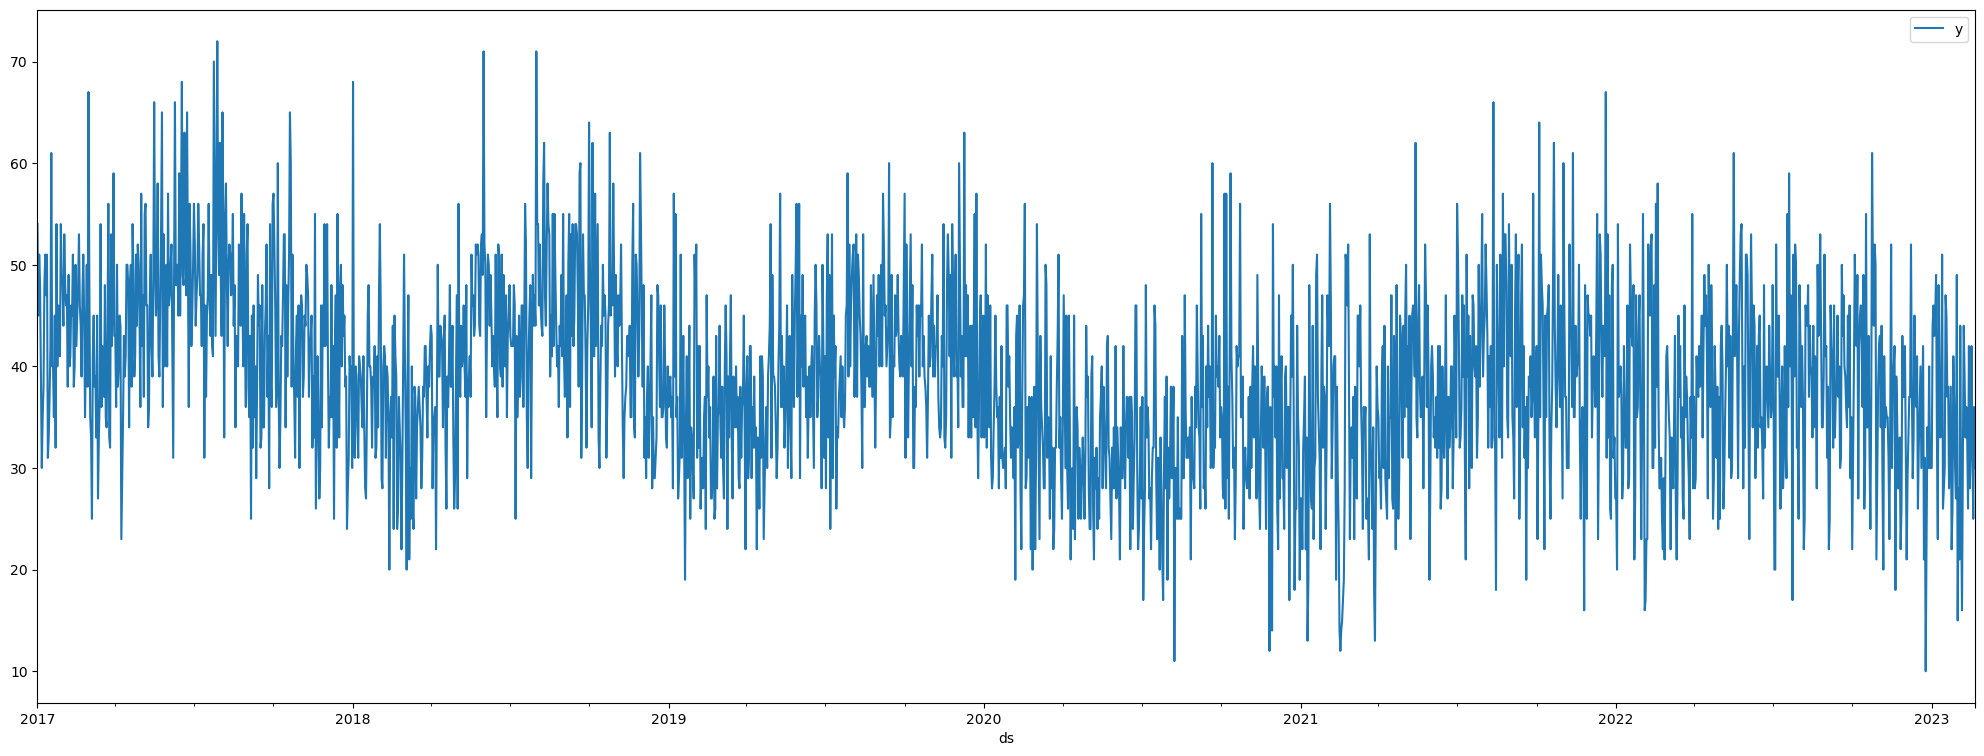

In [24]:
df2.set_index('ds').plot(figsize=(25, 9))

### Importing holidays from the holidays library and converting it to a dataframe to be used for Prophet model

In [25]:
import holidays

us_holidays = holidays.UnitedStates(years=[2017, 2018, 2019, 2020, 2021, 2022, 2023])
us_holidays = pd.DataFrame.from_dict(us_holidays, orient='index').reset_index()
us_holidays.columns = ['ds', 'holiday']
us_holidays['ds'] = pd.to_datetime(us_holidays['ds'])
us_holidays.tail()


,ds,holiday
80,2023-10-09,Columbus Day
81,2023-11-11,Veterans Day
82,2023-11-10,Veterans Day (Observed)
83,2023-11-23,Thanksgiving
84,2023-12-25,Christmas Day


### Setting train and test data as 80% and 20% of the dataset respectively.

In [26]:
train = df2[:int(0.8 * (len(df2)))]
test = df2[int(0.8 * (len(df2))):]
train.tail(), test.head()

(             ds   y
 1788 2021-11-24  33
 1789 2021-11-25  16
 1790 2021-11-26  48
 1791 2021-11-27  35
 1792 2021-11-28  25,
              ds   y
 1793 2021-11-29  47
 1794 2021-11-30  45
 1795 2021-12-01  45
 1796 2021-12-02  43
 1797 2021-12-03  45)

### Fitting the Prophet model with train data using optimally tuned hyperparameters and holidays dataframe.

In [27]:
m = Prophet(
    holidays=us_holidays,
    yearly_seasonality=True,
    holidays_prior_scale=1,
    seasonality_prior_scale=0.1,
    seasonality_mode='multiplicative',
)

m.fit(train)
future = m.make_future_dataframe(periods=test.shape[0])
forecast = m.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
2237,2023-02-16,40.592872,30.432127,50.536443
2238,2023-02-17,42.052336,31.477334,51.732509
2239,2023-02-18,36.970256,27.521243,46.916802
2240,2023-02-19,33.619756,23.908086,44.072159
2241,2023-02-20,42.172087,32.213149,52.291066


### Plotting the forecast along with actual values in test data.

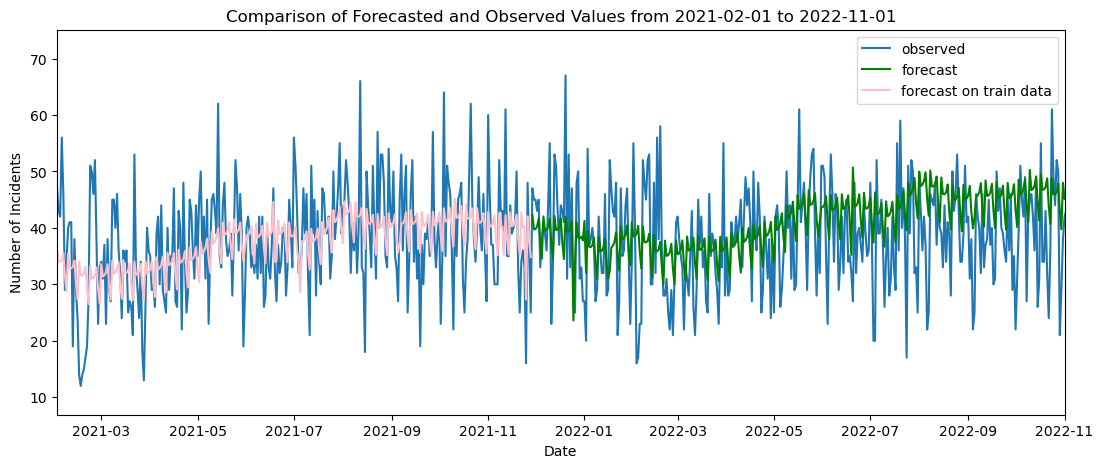

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13, 5))
plt.plot(df2.ds, df2.y, label='observed')

plt.plot(forecast[int(0.8 * (len(forecast))):]['ds'], forecast[int(0.8 * (len(forecast))):]['yhat'],
         label='forecast', color='green')
plt.plot(forecast[:int(0.8 * (len(forecast)))]['ds'], forecast[:int(0.8 * (len(forecast)))]['yhat'],
         label='forecast on train data', color='pink')

plt.title('Comparison of Forecasted and Observed Values from 2021-02-01 to 2022-11-01')
plt.xlabel('Date')
plt.ylabel('Number of Incidents')
plt.legend()
plt.xlim(pd.Timestamp('2021-02-01'), pd.Timestamp('2022-11-01'))
plt.savefig('../prophet-forecast.png')
plt.show()


In [29]:
test = test.merge(forecast[['ds', 'yhat']], how='left', on='ds')

### Plotting the forecast and visualizing possible seasonality of crimes.

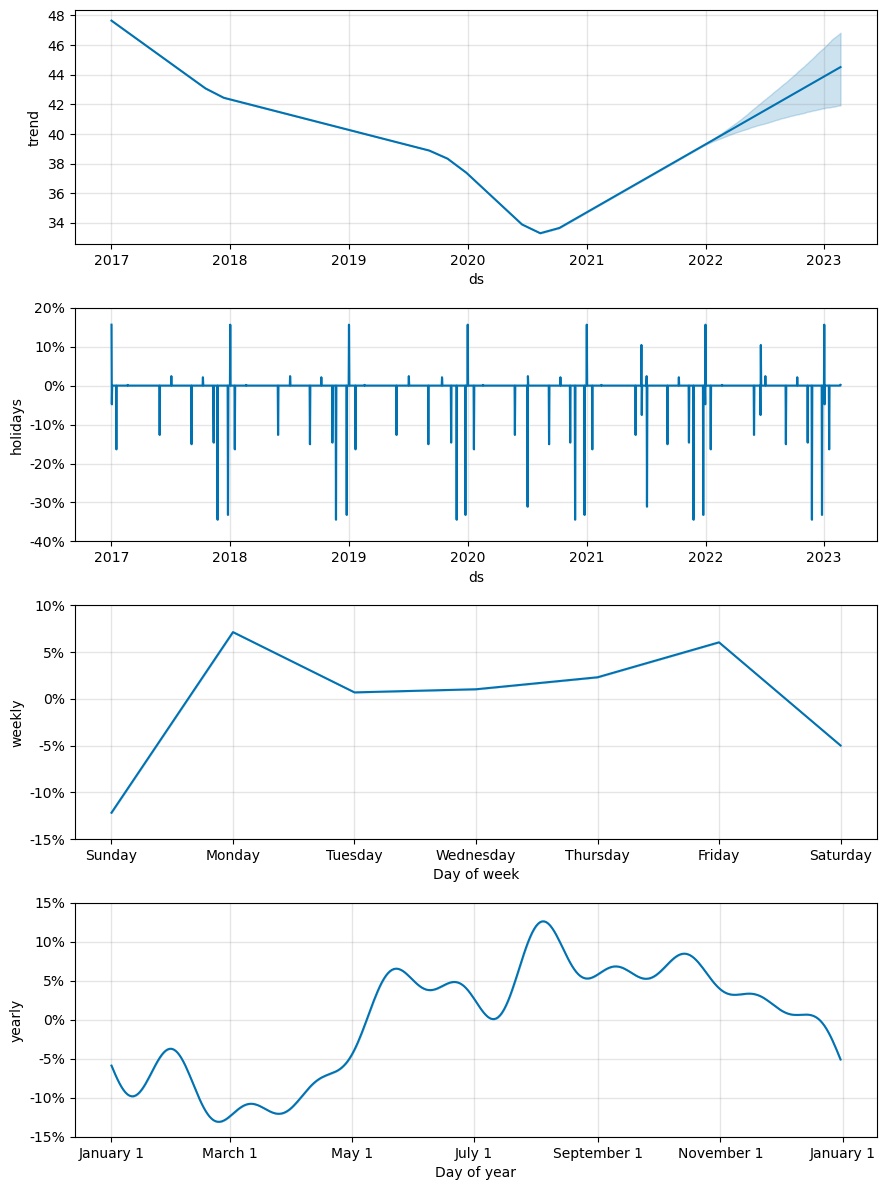

In [30]:
pt = m.plot_components(forecast)

In [31]:
plot_plotly(m, forecast, xlabel='Date', ylabel='Number of Incidents')


### Evaluating the model


In [32]:
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

predictions = test['yhat']
actual = test['y']

print('RMSE: ', rmse(actual, predictions))
print('MSE: ', mean_squared_error(actual, predictions))
print('MAE: ', mean_absolute_error(actual, predictions))
print('R2: ', r2_score(actual, predictions))

RMSE:  9.502805292668972
MSE:  90.30330843037741
MAE:  7.622779845986996
R2:  -0.09496519149957927


In [33]:
#How many crimes in 2017?
df2[df2['ds'].dt.year == 2017]['y'].sum()

16210